In [1]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from mogtrain import MoGTrainer

from tqdm import tqdm_notebook as tqdm

import delfi.distribution as dd

from delfi.utils.viz import probs2contours

from parameters import ParameterSet
import pickle

%matplotlib inline

In [2]:
params = pickle.load(open('example_mog.pkl', 'rb'))

In [3]:
prior = dd.Uniform(-params.x_width * np.ones(params.ndim), params.x_width * np.ones(params.ndim))
proposal = prior

In [4]:
def print_pdf(pdf, name):
    po = np.get_printoptions()
    np.set_printoptions(precision=2)
    print("{}:".format(name))
    print("----------------")
    print("Mixture weights: {}".format(pdf.a))
    print("Means:")
    for x in pdf.xs:
        print("{}".format(x.m))
    print()
    print("Covariances:")
    for x in pdf.xs:
        print("{}".format(x.S))
    print()
    np.set_printoptions(**po)

In [5]:
class DividedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, log=True):
        ret = self.a.eval(samples, log=log) / self.b.eval(samples, log=log)
        return ret / self.Z
    
def divide_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a / b
    
    return DividedPdf(a, b, norm_region)

In [6]:
trainer = MoGTrainer(proposal, prior, params.target, ncomponents=params.n_comps, nsamples=10000, lr=0.01, es_thresh=0, es_rounds=1000)

pred1 = trainer.get_mog()

print_pdf(pred1, "Init")
print_pdf(params.target, "Target")
losses = trainer.train(nsteps=-1)

pred = trainer.get_mog()

loss=[ 4.42357779]: : 6it [00:00, 34.09it/s]

Init:
----------------
Mixture weights: [ 0.2   0.09  0.35  0.14  0.22]
Means:
[-2.01  2.7 ]
[-3.93 -3.13]
[ 2.2   2.59]
[ 1.67  3.43]
[ 2.43  3.12]

Covariances:
[[ 0.82  0.77]
 [ 0.77  2.24]]
[[ 1.8  -0.36]
 [-0.36  0.4 ]]
[[ 2.74 -0.75]
 [-0.75  0.82]]
[[ 0.87 -0.14]
 [-0.14  0.41]]
[[ 1.04  1.26]
 [ 1.26  2.2 ]]

Target:
----------------
Mixture weights: [ 0.2   0.09  0.35  0.14  0.22]
Means:
[-2.01  2.7 ]
[-3.93 -3.13]
[ 2.2   2.59]
[ 1.67  3.43]
[ 2.43  3.12]

Covariances:
[[ 0.82  0.77]
 [ 0.77  2.24]]
[[ 1.8  -0.36]
 [-0.36  0.4 ]]
[[ 2.74 -0.75]
 [-0.75  0.82]]
[[ 0.87 -0.14]
 [-0.14  0.41]]
[[ 1.04  1.26]
 [ 1.26  2.2 ]]



loss=[ 4.42350912]: : 1048it [00:19, 53.95it/s]


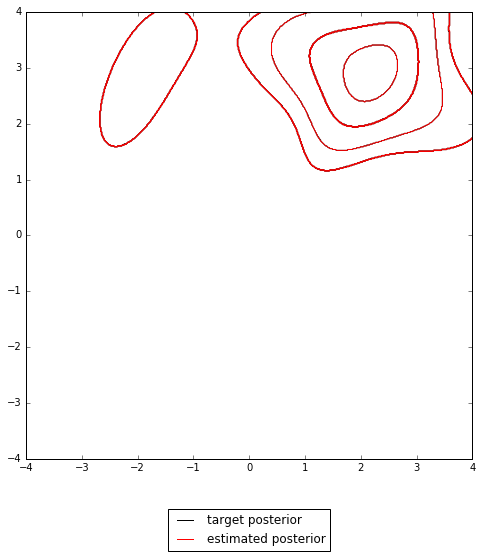

Target posterior:
----------------
Mixture weights: [ 0.2   0.09  0.35  0.14  0.22]
Means:
[-2.01  2.7 ]
[-3.93 -3.13]
[ 2.2   2.59]
[ 1.67  3.43]
[ 2.43  3.12]

Covariances:
[[ 0.82  0.77]
 [ 0.77  2.24]]
[[ 1.8  -0.36]
 [-0.36  0.4 ]]
[[ 2.74 -0.75]
 [-0.75  0.82]]
[[ 0.87 -0.14]
 [-0.14  0.41]]
[[ 1.04  1.26]
 [ 1.26  2.2 ]]

Estimated posterior:
----------------
Mixture weights: [ 0.2   0.09  0.35  0.14  0.22]
Means:
[-2.01  2.7 ]
[-3.93 -3.13]
[ 2.2   2.59]
[ 1.67  3.43]
[ 2.43  3.12]

Covariances:
[[ 0.82  0.77]
 [ 0.77  2.24]]
[[ 1.8  -0.36]
 [-0.36  0.4 ]]
[[ 2.74 -0.75]
 [-0.75  0.82]]
[[ 0.87 -0.14]
 [-0.14  0.41]]
[[ 1.04  1.26]
 [ 1.26  2.2 ]]



In [7]:
res = 500
xlims = (-params.x_width, params.x_width)
ylims = xlims

xaxis = np.linspace(*xlims, res)
yaxis = np.linspace(*ylims, res)
x, y = np.meshgrid(xaxis, yaxis)

xy = np.concatenate([x.reshape([-1, 1]), 
                     y.reshape([-1, 1])], 
                    axis=1)

levels = [0.7, 0.5, 0.3, 0.1]

target_contour = probs2contours(params.target.eval(xy, log=False), levels).reshape(res, res)
pred_contour = probs2contours(pred.eval(xy, log=False), levels).reshape(res, res)

plt.figure(figsize=(8, 8))

plt.contour(x, y, target_contour, colors=('k'))
plt.contour(x, y, pred_contour, colors=('r'))

black_line = mlines.Line2D([], [], color='k', label='target posterior')
red_line = mlines.Line2D([], [], color='r', label='estimated posterior')
plt.legend(handles=[black_line, red_line], 
           loc=9, bbox_to_anchor=(0.5, -0.1))

plt.show()

print_pdf(params.target, "Target posterior")
print_pdf(pred, "Estimated posterior")